# Aprendizado não supervisionado

Até o momento, já tivemos algumas experiências com aprendizagem de máquina (focando mais na parte supervisionada). Agora iremos adentrar em uma nova área do aprendizado: o *não-supervisionado*.

Quando queremos aprender algo que **já sabemos o que é** (a que classe pertence, o valor atribuído, etc.), é mais fácil de concebermos algumas ideias. Quando **não sabemos**, bom, as tarefas podem ficar mais abstratas. Vamos começar com o problema de *redução de dimensionalidade*.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Redução de Dimensionalidade

Quando trabalhamos com os dados para treinar modelos (ou até mesmo visualizá-los), manipulamos matrizes. Como já sabemos, operações matriciais podem ser custosas (não é a toa que usamos o numpy). Quando vimos as técnicas de gradiente, conseguimos lidar com datasets com muitas amostras entradas simplesmente lendo o dataset parcialmente (digamos, linha por linha), otimizando o uso de memória. Mas e quando nosso dado tem **muitas colunas**, ou seja, ele possui uma **alta dimensão**?

Trabalhar com altas dimensionalidades é computacionalmente custoso, o que torna o aprendizado lento (ou, em alguns casos, incomputável). Quando lidamos com esses dados, precisamos fazer a seguinte pergunta: será se eu preciso de tudo isso mesmo?

#### Vamos ao exemplo!

O dataset abaixo é o famoso [*Modified National Institute of Standards and Technology*](https://en.wikipedia.org/wiki/MNIST_database) (ou MNIST, para xs chegadxs), o qual traz consigo um conjunto de dígitos escritos a mão. A tarefa para esse dataset é, dada a imagem, identificar qual o dígito foi desenhado.

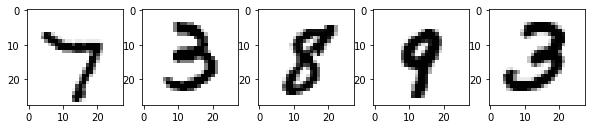

In [ ]:
# muitas libs trazem uma função para carregar o dataset
# embora o sklearn possua a sua própria, vamos usar a do keras,
# pois as imagens possuem resolução de 28x28 pixels
from keras.datasets import mnist
from sklearn.utils import resample

(images, labels), _ = mnist.load_data()

# vamos recuperar 5 imagens aleatórias
n_samples = 5
samples = resample(images, replace=False, random_state=42, n_samples=n_samples)

plt.figure(figsize=(10,5))
for i,sample in enumerate(samples):
  plt.subplot(1,n_samples,i+1)
  plt.imshow(sample, cmap="gray_r")
  # plt.axis('off')

Acima, temos as imagens do dataset. Como as imagens são 28x28 pixels, temos ao todo 784 valores para representar uma imagem. É muita coisa, certo? Será se precisamos de todos eles? Por quê? Se não, como que escolheríamos quais usar?

### Principais abordagens para redução de dimensionalidade

Uma abodagem bem ingênua para a redução de dimensionalidade, como você já deve ter imaginado, é manualmente escolher quais atributos a serem utilizados. Essa técnica, embora simples, tem seu valor: quando trabalhamos com dados onde temos o domínio bem conhecido, ou conseguimos identificar atributos sem variância ou com muito ruído ou dado sujo (ex: idades de 203 anos), podemos fazer essa seleção manualmente. Mas quando não conseguimos?

Vamos visualizar o exemplo abaixo:

In [ ]:
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

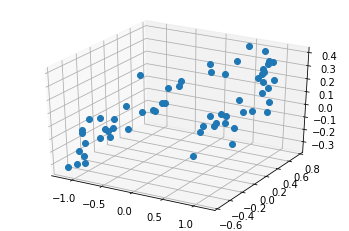

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(X[:,0], X[:,1], X[:,2], 'o');

Ok, 3 dimensões é algo que ainda conseguimos ver. Mas e se fosse maior? Se fosse algo que não fosse visível?

Podemos usar nossa queria álgebra linear para tentar fazer algo um pouco mais elegante do que simpesmente *escolher* os atributos: podemos **projetar** o dado em uma **dimensão menor**!

Vamos ao exemplo abaixo:

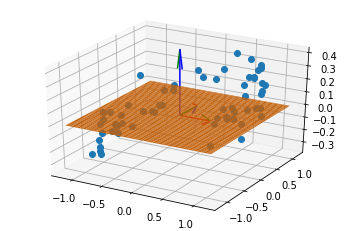

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(X[:,0], X[:,1], X[:,2], 'o')

x = y = np.linspace(X.min(),X.max(),100)

xx,yy = np.meshgrid(x,y)
zz = np.zeros(xx.shape[0]).reshape(-1,1)
# zz = 0.1*xx + 0.001*yy
ax.plot_surface(xx,yy,zz);

origin = np.array([0, 0, 0]) # origin point
ax.quiver3D(origin, origin, origin, [1,0,0], [0,1,0], [0,0,1], length=.5, color=['r','g','b']);

Por questões de simplicidade, definimos um *hiperplano* de 2 dimensões, o qual é definido pelos vetores $[1,0]$ e $[0,1]$ (ou seja, é basicamente o espaço 2D que estamos acostumados). Se projetarmos todos os pontos nesse novo plano, teremos a seguinte representação:

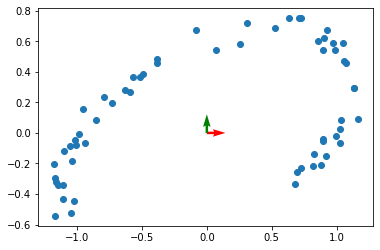

In [ ]:
_ = plt.scatter(X[:,0], X[:,1])
_ = plt.quiver([0,0], [0,0], [1,0], [0,1], color=['r','g'])

Olha que interessante: projetando o dado nesse *hiperplano* de 2 dimensões, visualmente, o dado parece ter sido preservado. Logo, podemos ter uma boa representação.

Vamos agora para um exemplo mais complexo: o rolo suíço! (ou rocambole, bolo de rolo, dentre outras variantes)

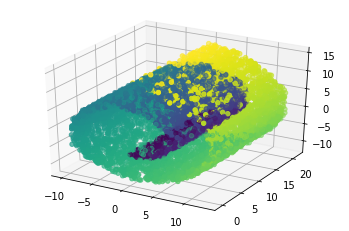

In [ ]:
from sklearn.datasets import make_swiss_roll
X, Y = make_swiss_roll(n_samples=10000, noise=0.2, random_state=42)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
_ = ax.scatter(X[:,0], X[:,1], X[:,2], c=Y)

É agora que as coisas ficam mais complicadas... Será se conseguimos definir um *hiperplano* de 2 dimensões que vai representar bem esse dado?

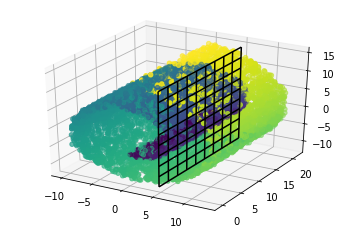

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
_ = ax.scatter(X[:,0], X[:,1], X[:,2], c=Y)

x0 = np.linspace(X[:,0].min(), X[:,0].max(), 10)
x1 = np.linspace(X[:,1].min(), X[:,1].max(), 10)
x2 = np.linspace(X[:,2].min(), X[:,2].max(), 10)

_ = ax.plot_wireframe(5,*np.meshgrid(x1,x2), alpha=1, color='k')

Pela visualização acima, não temos como ter certeza. Vamos experimentar projetar as componentes de 2 em 2, combinando as possibilidades.

**Note**: as projeções abaixo são nos eixos XY, XZ e YZ. Não estamos experimentando com *hiperplanos* mais complexos para simplificar a matemática.

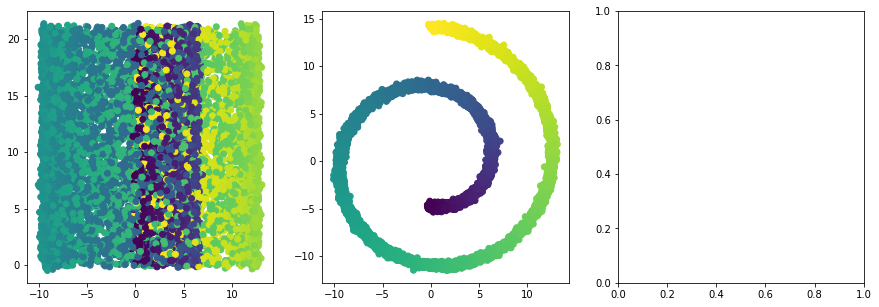

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.scatter(X[:,0], X[:,1], c=Y)

plt.subplot(1,3,2)
plt.scatter(X[:,0], X[:,2], c=Y)

plt.subplot(1,3,3);

É... não ficou legal. Mas por que será?

Esse dataset é o que é conhecido como *Mainfold*: temos um espaço 2D que foi *torcido* em uma terceira dimensão. De forma mais genérica: um espaço *d-dimensional* foi torcido em um um espaço em um espaço *n-dimensional* (com n > d).

Para lidar com esse tipo de dado, precisamos utilizar técnicas de *aprendizado de Mainfold*. Para isso, é necessário **assumir** que o dado é um caso de *Mainfold*. 

Mas não temam! Para essa aula, vamos focar mesmo em **projeções**.

### Análise de Componentes Principais (PCA)

Essa é, de longe, a técnica mais popular para redução de dimensionalidade. Ela consiste em identificar um *hiperplano* de dimensionalidade menor e projetar os dados nele. Basicamente o que vimos anteriormente, certo?

Mas o segredo aqui mora em *como criar esse hiperplano*.

Vamos ao exemplo abaixo, onde temos um dataset 2D e fazemos projeções 1D:

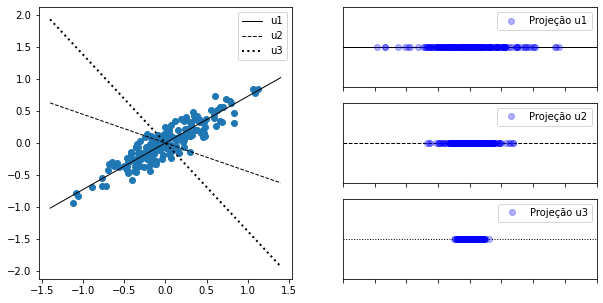

In [ ]:
plt.figure(figsize=(10,5))
stretch = 5
m = 200
angle = np.pi / 5

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(np.pi/5), np.sin(np.pi/5)], [-np.sin(np.pi/5), np.cos(np.pi/5)]]) # rotate
plt.subplot(1,2,1)
plt.scatter(X[:,0],X[:,1])

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1, label="u1")
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1, label="u2")
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2, label="u3")
plt.legend()

X_proj1 = X.dot(u1)
X_proj2 = X.dot(u2)
X_proj3 = X.dot(u3)

plt.subplot(3,2,2)
plt.axis([-2, 2, -1, 1])
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1, np.zeros(m), 'bo', alpha=.3, label="Projeção u1")
plt.legend()
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])

plt.subplot(3,2,4)
plt.axis([-2, 2, -1, 1])
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2, np.zeros(m), 'bo', alpha=.3, label="Projeção u2")
plt.legend()
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])

plt.subplot(3,2,6)
plt.axis([-2, 2, -1, 1])
plt.plot([-2, 2], [0, 0], "k:", linewidth=1)
plt.plot(X_proj3, np.zeros(m), 'bo', alpha=.3, label="Projeção u3")
plt.legend()
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([]);

Acima, temos 3 vetores (que chamaremos de componentes) os quais utilizamos para fazer projeções: *u1*, *u2* e *u3*. Os gráficos à direita representam como os dados ficam ao serem projetados nessas componentes. O que podemos observar?

Bom, os dados projetados em *u3* estão muito próximos, ou seja, nessa projeção, é como se fossem informações bem parecidas, *variando muito pouco*. Em contrapartida, em *u1* os dados estão bem dispersos.

**Vamos refletir**: qual das 3 projeções seria melhor? Devemos priorizar variâncias maiores, menores ou devemos ter um equilíbrio?

**Dica**: quando queremos extrair conhecimento dos dados, buscamos formas de *separá-los*.

Antes de entrar em detalhes, vamos tentar visualizar o dataset IRIS utilizando apenas 2 de suas componentes. As possibilidades são as seguintes:

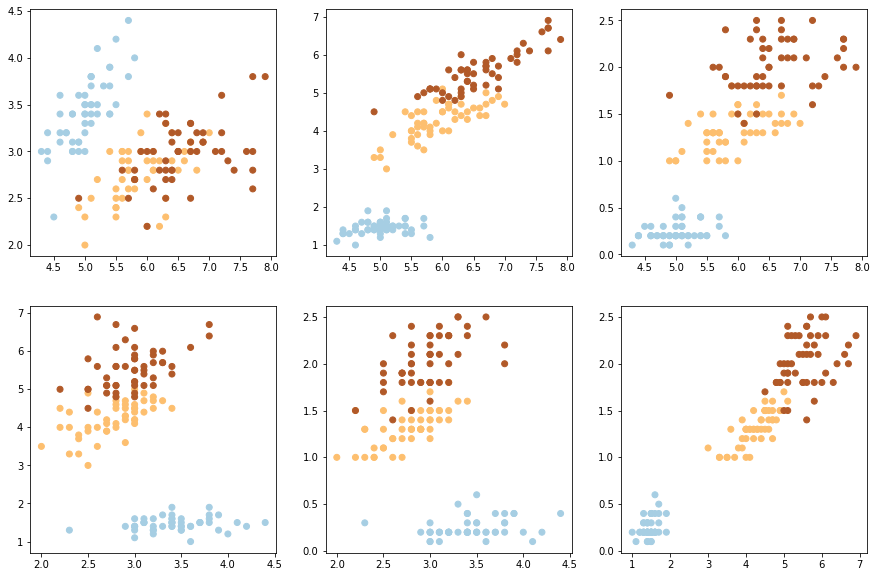

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
Y = iris.target

plt.figure(figsize=(15,10))
k = 1
for i in range(X.shape[1]):
  for j in range(i+1, X.shape[1]):
    plt.subplot(2,3,k)
    plt.scatter(X[:,i], X[:,j], c=Y, cmap="Paired")
    k += 1

A ideia por traz do PCA busca encontrar o hiperplano que **maximiza** a variância dos dados projetados. Ou seja, ela busca encontrar as *componentes* que, ao projetar o dado, ele fique o mais disperso possível. E olha que interessante: se você quer projetar o dado em d-dimensões, ele vai escolher as d-componentes de maior variância!

#### Tá, mas como que isso acontece?

Não vamos entrar em detalhes da matemática, mas o segredo está na *auto decomposição* da *matriz de covariância* dos dados. Antes que você entre em pânico, vamos explicar o que é isso:

- A *auto decomposição* de uma matriz são os auto vetores e auto valores dessa matriz. Dada a equação $A \cdot u = \lambda \cdot u$, onde $A$ é nossa matriz, $\lambda$ é o auto valor (escalar) e $u$ é o auto vetor;

- A matriz de covariância é uma matriz que representa como os atributos variam entre si, medindo sua disperção.

Com o numpy, uma maneira simples de realizar essas contas é utilizando a [*Decomposição de valores singulares*](https://en.wikipedia.org/wiki/Singular_value_decomposition#Relation_to_eigenvalue_decomposition)(SVD):

In [ ]:
# o PCA assume que os dados possuem média 0,
# Logo, precisamos subtrair a média dos dados originais
X_centered = X - X.mean(axis=0)

# o SVD retorna 3 elementos. Precisaremos apenas dos último
_, Sigma, Vt = np.linalg.svd(X_centered)

# as colunas são as componentes
print(f"Componentes:\n{Vt.T}\n")

Componentes:
[[ 0.36138659 -0.65658877  0.58202985  0.31548719]
 [-0.08452251 -0.73016143 -0.59791083 -0.3197231 ]
 [ 0.85667061  0.17337266 -0.07623608 -0.47983899]
 [ 0.3582892   0.07548102 -0.54583143  0.75365743]]



#### Explicando um pouco do SVD

O SVD realiza a decomposição $A = U \Sigma V$, onde:
- $U$ é a matriz de auto vetores de $A A^T$;
- $V$ é a matriz de auto vetores de $A^T A$ (que, quando A tem média 0, é sua matriz de covariância);
- $\Sigma$, que representa a raiz dos auto valores de $A A^T$ ou $A^T A$.

As colunas de `Vt` são as componentes dos *hiperplanos* que podemos construir. Para projetar o dado em d dimensões, basta utilizarmos as d primeiras componentes e multiplicar!

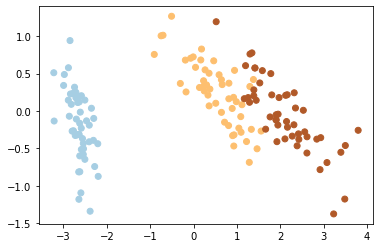

In [ ]:
X_proj = X_centered.dot(Vt.T[:,:2])
plt.scatter(X_proj[:,0], X_proj[:,1], c=Y, cmap="Paired");

Agora que já vimos o que é o PCA, vamos ver como usar sua implementação pelo sklearn:

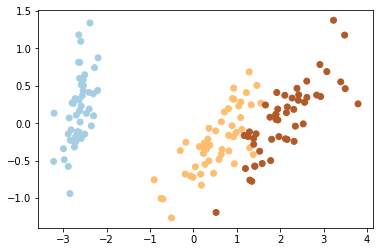

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

# na implementação do sklearn, não precisamos subtrair a média dos dados!
X_proj = pca.fit_transform(X)

plt.scatter(X_proj[:,0], X_proj[:,1], c=Y, cmap="Paired");

Mas espera um pouco... esses gráficos ficaram diferentes. Por que a projeção que fizemos usando o SVD ficou diferente da feita com o sklearn? O que vocês acham?

**Dica**: as duas estão certas.

#### *Explained Variance*

Uma coisa muito interessante do PCA é que, a gente aproveita TUDO da sua matemática!

Olha que interessante: nós encontramos os auto vetores, que são as componentes principais para a projeção. Só que, atrelado aos auto vetores existem auto valores, um para cada auto vetor. O que será que isso quer dizer?

Algumas observações que podem ser úteis:

- os auto valores vêm ordenados de forma decrescente;
- eles são todos positivos

In [ ]:
pca.explained_variance_, pca.explained_variance_ratio_

(array([4.22824171, 0.24267075]), array([0.92461872, 0.05306648]))

In [ ]:
from sklearn.datasets import make_classification
x,_ = make_classification(n_features=100, n_informative=5, n_redundant=90)
p = PCA(n_components=5)
p.fit(x)
p.explained_variance_ratio_.sum()

0.9890378108333272

In [ ]:
pca = PCA(n_components=0.90) # preserva 95% da variância
pca.fit(X)
pca.explained_variance_ratio_

array([0.92461872])

#### Utilizando o PCA junto de um modelo supervisionado

Vamos agora testar o PCA em conjunto com um modelo supervisionado e ver o que acontece com o aprendizado.

Vamos fazer algo bem simples:
- usaremos o dataset IRIS;
- divisão de treino/teste 80/20 (não utilizaremos validação, por questões de simplicidade);
- treinaremos um modelo de regressão logística;
- avaliaremos apenas com a acurácia.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,train_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, Y_train)
model.score(X_test, Y_test)

0.9666666666666667

Ok, temos uma acurácia bem alta já. Será que o PCA vai piorar muito? Ou será se vai melhorar?

In [ ]:
pca = PCA(n_components=4)
X_train_proj = pca.fit_transform(X_train)
print(pca.explained_variance_ratio_)
model = LogisticRegression()
model.fit(X_train_proj, Y_train)
model.score(pca.transform(X_test), Y_test)

[0.90170552 0.07036548 0.02233406 0.00559494]


0.9666666666666667

Olha só... o resultado ficou melhor! Projetando o dado em 2D, conseguimos melhorar o resultado. Mas saiba que isso **não é uma regra**. Quando realizamos projeções com o PCA, dados são *perdidos*. As vezes pouco, as vezes muito. Logo, isso afeta o treinamento. Nesse caso, afetou positivamente.

**Note**: o PCA foi treinado, assim como a regressão logística, utilizando os *dados de treino*. Em seguida, os *dados de teste* foram transformados por ele.

### Voltando aos dígitos

Agora que sabemos reduzir dimensões e vimos que funciona, vamos revisitar o MNIST

In [ ]:
images.shape

(60000, 28, 28)

Wow... é muito dado, certo? Não só em termos de amostras, mas também em termos de atributos também! 60000 amostras com 784 atributos!

Vamos fazer algo ousado: vamos aplicar o PCA sobre eles, reduzindo para 2 dimensões, e por no gráfico! (a maldade está nos olhos de quem lê)

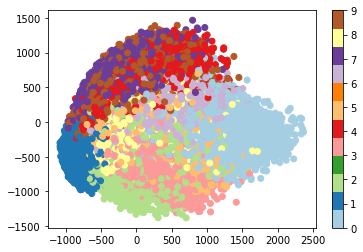

In [ ]:
pca = PCA(n_components=2)
images_projected = pca.fit_transform(images.reshape(images.shape[0],-1))
s = plt.scatter(images_projected[:,0], images_projected[:,1], c=labels, cmap="Paired")
plt.colorbar(s);

#### QUE BAGUNÇA!

É, não dá nem pra visualizar isso e tentar identificar qual ponto é qual dígito.

Mas espera um pouco... vamos ver as matrizes que temos:

In [ ]:
images.shape, images_projected.shape

((60000, 28, 28), (60000, 2))

Nossa... é gritante a diferença de dados entre o original e o projetado, certo? Como é que podemos saber se a perda de dados foi muito grande? Será se esse dado que temos ainda representa bem os dados originais?

In [ ]:
pca.explained_variance_ratio_

array([0.09704664, 0.07095924])

Temos pouco mais de 16% da variância original preservada. Muito pouco, não é? Bom, sempre podemos aumentar a dimensão da projeção e melhorar isso. Mas não é bem esse ponto que desejamos tocar agora.

Se analisarmos a matemática por traz do PCA, podemos ver que a operação de projeção é **invertível**, ou seja, um dado *projetado* pode ser *reconstruído* para o espaço original. Quando o espaço projetado é **menor** que o original, haverá um **erro** na reconstrução. Mas qual a vantagem disso?

Bom, vamos reconstruir as imagens, de 2 dimensões para 784 e, em seguida, reajustar para matrizes 28x28 :

In [ ]:
images_reconstructed = pca.inverse_transform(images_projected).reshape(-1,28,28)
images_reconstructed.shape

(60000, 28, 28)

Será se... essas imagens reconstruídas.... são boas?

Vamos experimentar!

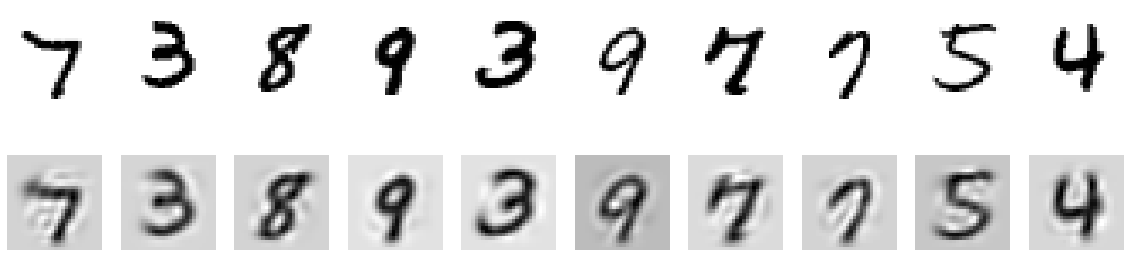

In [ ]:
pca = PCA(n_components=50)
images_projected = pca.fit_transform(images.reshape(images.shape[0],-1))
images_reconstructed = pca.inverse_transform(images_projected).reshape(-1,28,28)

n_samples = 10
samples_idx = resample(range(images.shape[0]), replace=False, random_state=42, n_samples=n_samples)
fig = plt.figure(figsize=(20,5))
plt.gray()
for i,idx in enumerate(samples_idx):
  plt.subplot(2,n_samples,i+1)
  plt.imshow(images[idx], cmap="gray_r")
  plt.axis('off')

  plt.subplot(2,n_samples,i+1+n_samples)
  plt.imshow(images_reconstructed[idx], cmap="gray_r")
  plt.axis('off')

In [ ]:
images_data = images.reshape(60000,-1)

X_train, X_test, Y_train, Y_test = train_test_split(images_data,labels,train_size=0.2, random_state=42)

model = LogisticRegression()
sc.fit(X_train)
model.fit(sc.transform(X_train), Y_train)
model.score(sc.transform(X_test), Y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8785833333333334

In [ ]:
pca = PCA(n_components=200)
X_train_proj = sc.fit_transform(pca.fit_transform(X_train))
model = LogisticRegression()
model.fit(X_train_proj, Y_train)
model.score(sc.transform(pca.transform(X_test)), Y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8954583333333334

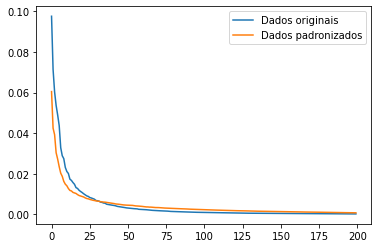

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
pca = PCA(n_components=200)

pca.fit(X_train)
plt.plot(pca.explained_variance_ratio_, label="Dados originais")

pca.fit(sc.fit_transform(X_train))
plt.plot(pca.explained_variance_ratio_, label="Dados padronizados");
plt.legend();

É... 2 dimensões pra representar 784 é meio que forçar a barra, certo?

Experimente outros valores para a projeção (seja informando o número de componentes ou a porcentagem da variância preservada) e veja o que acontece!

Olha só que interessante: com menos de 200 dimensões, somos capazes de preservar o dado o suficiente para sermos capazes de reconstruir as imagens com uma boa qualidade! De 784 para 200 é uma redução de quase 75% do tamanho original! 

**Olha que interessante**: isso não apenas pode acelerar o seu treinamento, como também funciona como um tipo de **compressão de dados**! Se você salvar as imagens projetadas e as componentes utilizadas, você consegue reconstruir o dataset original!

### Para expandir os horizontes (ou bugar a mente de vez)

Existe uma outra técnica similar chamada de *Probabilistic Principal Component Analysis*, a qual utiliza distribuições probabilísticas para realizar as projeções. Isso permite que ela não apenas reduza a dimensionalidade, mas também **gere novos dados** a partir do que foi utilizado no treinamento!

No [GitHub](https://github.com/lucaspg96/probabilistic-ml/blob/master/Trabalho%205/PPCA.ipynb) tem uma (humilde) implementação que explica essa técnica com alguns exemplos.

### Questionamentos para fixação

Sobre o PCA:

- É uma técnica de aprendizado supervisionado ou não? Por quê?
- Qual a tarefa de aprendizado do PCA?
- Como que podemos escolher a dimensão do espaço projetado?

### Outras técnicas de redução de dimensionalidade

Nesta aula, aprendemos sobre o PCA (embora tenhamos passado por cima de parte da sua matemática). Um fato interessante sobre ele é que ele possui variações:

- PPCA (mencionado anteriormente);
- *Randomized PCA*, uma alternativa ao PCA padrão que tenta encontrar a solução ótima sem ter de realizar a auto decomposição completamente;
- *Incremental PCA*, que treina o PCA *parcialmente*, permitindo percorrer os dados em lotes individuais e encontrar uma representação para o dado como um todo;
- *Kernel PCA* utiliza uma técnica chamada de *kernel trick*, que projeta o dado em um espaço **maior**, permitindo que dados não lineares possam tornar-se lineares e, em seguida, projeta em um espaço **menor**.